### 分類問題 (classification)
### MNIST data: 手書き数字認識 (hand-written character of digits)
MNIST: Modified National Institute of Standards and Technology database

NIST: アメリカ国立標準技術研究所 (米商務省機関，情報技術関連では暗号の AES やハッシュの SHS (SHA-0,1,2,3) 等．DES はこの前身機関が標準化)
<img src="01-MNIST1.png">

## 深層学習をつかってみる (deep neural network, or deep learning)


## Keras / TensorFlow
- TensorFlow は柔軟性が高いが，既存のニューラルネットワークを定義は困難である．
- Keras は，畳み込みニューラルネットなど，深層学習として広く知られているものを簡潔に定義することができる．
- 階層型ニューラルネットの層（レイヤー）構造を直観的に構築できる．

### Keras でニューラルネットを構築する．
パーセプトロン（旧来からのニューラルネット），および畳み込みニューラルネット（近年の深層学習）のためのライブラリを読み込む．



In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KMP_AFFINITY'] = 'disabled'
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
keras.backend.set_session(keras.backend.tf.Session(config=keras.backend.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


#### クラスの数 (10)を定義しておきます．
- MNIST の分類クラスは，数字「0」～「9」の10クラス

In [3]:
n_classes=10

### MNIST データのロード
- 下記のように，学習データの入力 x, 出力 y, テストデータの入力 x, 出力 y をまとめて代入
- データはサーバのファイル /home/mnist/mnist.npz にある
- .npz は NumPy の配列 ndarray の圧縮形式
- x_train : 学習用入力データ
- y_train : 学習用出力データ
- x_test: テスト用入力データ
- y_test: テスト用出力データ


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path="/home/mnist/mnist.npz")

### データがどのような形式か確認
- Python のオブジェクトの型を調べる関数 type()

In [11]:
type(x_train)


numpy.ndarray

In [6]:
type(x_test)

numpy.ndarray

In [7]:
type(y_train)

numpy.ndarray

mnistのデータは，NumPy の n次元配列 (ndarray) であることがわかる．

### 配列の次元（形）を把握

In [12]:
x_train.shape

(60000, 28, 28)

In [13]:
x_test.shape

(10000, 28, 28)

In [14]:
y_train.shape

(60000,)

In [15]:
y_test.shape

(10000,)

In [20]:
x_train[0].max()

255

In [18]:
x_train[0].min()

0

In [19]:
x_train[0].mean()

35.108418367346935

### 同様に，出力も見てみましょう．
- y_trainを見てみる

In [21]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

「5」, 「0」，「4」など，画像のラベルである数字が60000個ある

## Matplotlib の機能を使ってデータの画像を見てみる
- Matplotlib は，python用グラフ描画ツールです．
- `imshow()` 関数を用いることで，NumPy の2次元配列をそのまま画像としてみることができます
- plt.imshow(x_train[0]) としてみる

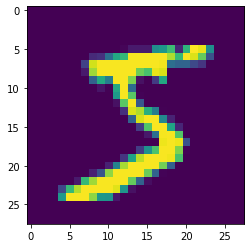

In [24]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
plt.show()

各要素に色をつけて画像として表示

黄色と紫，どちらが0でどちらが255か？

`plt.colorbar()`を入れるとカラーバーを表示してくれます

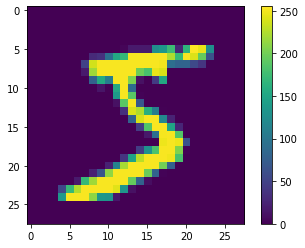

In [23]:
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

- デフォルトの色が少し変なので，カラーマップをグレースケールにする

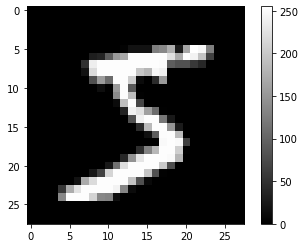

In [25]:
plt.imshow(x_train[0], cmap='gray')
plt.colorbar()
plt.show()

- さらに，0 が黒，255 が白となっているのを，白黒反転してみる．

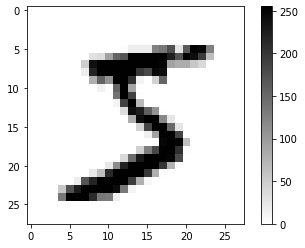

In [26]:
plt.imshow(x_train[0], cmap='gray_r')
plt.colorbar()
plt.show()

- 出力ラベルを確認すると確かに「5」である．


In [27]:
y_train[0]

5

次に，入力訓練データ x_train, 入力テストデータ x_test　を 28x28 の2次元配列から，784要素の1次元配列に変換します．

これは，学習器に，全画素を独立変数（＝説明変数＝入力の変数）として入力するためです．

（配列のフラット化と言います）

ここまでを実行するコードは下記のようになります．

最後に，Keras に入力するために，単精度浮動小数点 (32 bit)に変換する．

In [28]:
data_size=1000
x_train_fl = x_train.reshape(60000, 784)
x_train1 = x_train_fl[0:data_size]
x_train1 = x_train1.astype('float32')

x_train1 と x_test1 を shape 属性で確認

In [29]:
x_test_fl = x_test.reshape(10000, 784)
x_test1 = x_test_fl[0:data_size]
x_test1 = x_test1.astype('float32')

In [31]:
x_train1.shape

(1000, 784)

In [32]:
x_test1.shape

(1000, 784)

両者とも，(1000, 784) (784要素の1次元配列が，1000個集まった，1000x784 2次元配列）であればよい

出力の変数 y は，0-9 の数値データになっているが，実際にはカテゴリカル（「0」～「9」のクラス）とする必要があり，ニューラルネットで多クラス分類するためには，カテゴリカルにする必要がある（ダミー変数化と同様の変換）ので，それを行う．One Hot Encodingされたものは`y_train_c`

In [30]:
y_train_c = keras.utils.to_categorical(y_train, n_classes)
y_train_c = y_train_c[0:data_size]
y_test_c = keras.utils.to_categorical(y_test, n_classes)
y_test_c = y_test_c[0:data_size]

今度はカテゴリ化した `y_train_c` の形を確認

In [34]:
y_train_c

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

次に `y_train_c[0]` を確認でき、`y_train[0]`は正しく変換されたと言える！

In [36]:
y_train_c[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## ニューラルネットモデル作成手順

### 単層パーセプトロン (Perceptron)

- まず初めに　model名 = Sequential() で定義を始める
- 入力が 784 次元
- 出力は n_classes (上で定義したもの)の，Dense型の層を1つ作る
- 活性化関数 (activation function) をシグモイド関数の多クラス版である，ソフトマックス (softmax) 関数とする

In [39]:
perceptron = Sequential()
perceptron.add(Dense(n_classes, activation='softmax', input_shape=(784,)))

モデルの層構造，ニューロン数を確認．

In [40]:
perceptron.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


- dense_1 (Dense) という1行だけが存在
- これは，1層だけのニューラルネットワークであることを示している

次にモデルを実行可能な状態にコンパイルする．

In [42]:
perceptron.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

## 作成したニューラルネットの学習を行う．
- 学習は，関数近似（関数のあてはめ）であるので，「fit」と呼ぶ
- model.fit メソッドを使う
- さらに，学習過程を後で確認するために，history オブジェクトに学習途中の状態を格納する．
- バッチサイズは，32 としておく
- エポック数は 8 とする．

In [53]:
history_perceptron = perceptron.fit(x_train1, y_train_c,
                                  batch_size=32,
                                  epochs=8,
                                  verbose=1,
                                  validation_data=(x_test1, y_test_c))

Train on 1000 samples, validate on 1000 samples
Epoch 1/8
1000/1000 [==============================] - 0s 101us/step - loss: 7.5158 - acc: 0.5300 - val_loss: 8.3379 - val_acc: 0.4760
Epoch 2/8
1000/1000 [==============================] - 0s 87us/step - loss: 7.5284 - acc: 0.5300 - val_loss: 8.1238 - val_acc: 0.4900
Epoch 3/8
1000/1000 [==============================] - 0s 117us/step - loss: 7.2369 - acc: 0.5480 - val_loss: 8.1421 - val_acc: 0.4900
Epoch 4/8
1000/1000 [==============================] - 0s 129us/step - loss: 7.1679 - acc: 0.5520 - val_loss: 7.9781 - val_acc: 0.4990
Epoch 5/8
1000/1000 [==============================] - 0s 106us/step - loss: 7.1107 - acc: 0.5550 - val_loss: 7.9330 - val_acc: 0.5020
Epoch 6/8
1000/1000 [==============================] - 0s 138us/step - loss: 7.1478 - acc: 0.5550 - val_loss: 7.7360 - val_acc: 0.5150
Epoch 7/8
1000/1000 [==============================] - 0s 139us/step - loss: 7.1719 - acc: 0.5500 - val_loss: 7.7208 - val_acc: 0.5160
Epoch 8/

モデルをファイルに保存

In [46]:
perceptron.save('perceptron.h5')

### 認識精度（識別率）を確認する
- model.evaluate にテスト入力データと，テスト出力データを指定する．

In [54]:
score_perceptron = perceptron.evaluate(x_test1, y_test_c, verbose=1)
print('Test loss:', score_perceptron[0])
print('Test accuracy:', score_perceptron[1])

1000/1000 [==============================] - 0s 52us/step
Test loss: 7.897923828125
Test accuracy: 0.504


## 上記でセーブしたモデルを予測器として実際に手書き認識させてみる

### 評価のためのテストデータを作成

In [55]:
predicted = perceptron.predict_classes(x_test1)
expected = y_test[0:data_size]

### Scikit Learn の metrics クラスを使う

In [56]:
from sklearn import metrics
print(metrics.confusion_matrix(expected, predicted))
print(metrics.classification_report(expected, predicted))

[[  0   0  38   0   0  37   5   5   0   0]
 [  0 120   2   0   0   3   0   1   0   0]
 [  0   5 102   0   0   4   0   4   0   1]
 [  0   2  14   0   0  85   0   4   0   2]
 [  0   1  24   0   0  21   7  16   0  41]
 [  0   1   1   0   0  78   0   5   0   2]
 [  0   0  12   1   0   6  65   3   0   0]
 [  0   1   6   0   0   2   0  86   0   4]
 [  0   3  24   0   0  51   1   6   0   4]
 [  0   0   4   0   0   9   0  28   0  53]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.90      0.95      0.93       126
           2       0.45      0.88      0.59       116
           3       0.00      0.00      0.00       107
           4       0.00      0.00      0.00       110
           5       0.26      0.90      0.41        87
           6       0.83      0.75      0.79        87
           7       0.54      0.87      0.67        99
           8       0.00      0.00      0.00        89
           9       0.50     

### Seaborn で可視化すると見やすい

Text(0.5, 200.75999999999993, 'Predicted label')

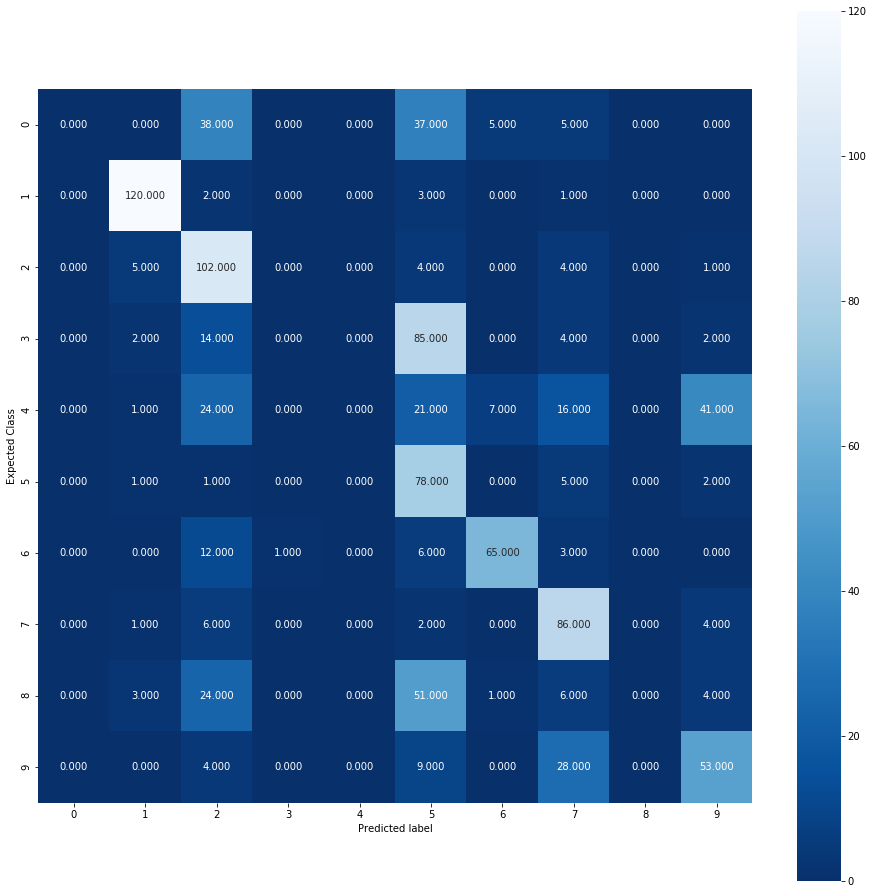

In [58]:
import seaborn as sns
confmat = metrics.confusion_matrix(expected, predicted)
plt.figure(figsize=(16,16))
sns.heatmap(confmat, annot=True, fmt=".3f", square = True, cmap = 'Blues_r')
plt.ylabel('Expected Class')
plt.xlabel('Predicted label')

### 層を増やしてみる
#### 多層パーセプトロン (Multi Layer Perceptron, MLP) を行う
- model = Sequential() の後に，model.addを増やしていく．
- 下記は，2層にする例．
- 入力の次の層は，ニューロン数 1000 としている
- 活性化関数に relu (rectified linear) というのを用いる

In [59]:
mlp = Sequential()
mlp.add(Dense(1000, activation='relu', input_shape=(784,)))
mlp.add(Dense(n_classes, activation='softmax'))

In [60]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10010     
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________


In [61]:
mlp.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

モデルを実行してください．history も残してください．

In [62]:
history_mlp = mlp.fit(x_train1, y_train_c,
                      batch_size=32,
                      epochs=8,
                      verbose=1,
                      validation_data=(x_test1, y_test_c))

Train on 1000 samples, validate on 1000 samples
Epoch 1/8
1000/1000 [==============================] - 2s 2ms/step - loss: 14.2324 - acc: 0.1170 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 2/8
1000/1000 [==============================] - 1s 860us/step - loss: 14.2323 - acc: 0.1170 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 3/8
1000/1000 [==============================] - 1s 853us/step - loss: 14.2323 - acc: 0.1170 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 4/8
1000/1000 [==============================] - 1s 641us/step - loss: 14.2323 - acc: 0.1170 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 5/8
1000/1000 [==============================] - 1s 677us/step - loss: 14.2323 - acc: 0.1170 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 6/8
1000/1000 [==============================] - 1s 601us/step - loss: 14.2323 - acc: 0.1170 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 7/8
1000/1000 [==============================] - 1s 679us/step - loss: 14.2323 - acc: 0.1170 - val_loss: 14.5224 - val_acc: 0.

認識精度を確認してください

In [63]:
score_mlp = mlp.evaluate(x_test1, y_test_c, verbose=1)
print('Test loss:', score_mlp[0])
print('Test accuracy:', score_mlp[1])

1000/1000 [==============================] - 0s 259us/step
Test loss: 14.522403778076171
Test accuracy: 0.099


# 精度が悪い理由は，データのノーマライズをしていないから
- Scikit Learn では実はノーマライズ（データの標準化）が入っていた
- Kerasにはないので，ここでは単純に正規化（0-255 の画素値を 0-1にする）してみる
- x_train1, x_test1を255で除する

In [64]:
x_train1_n = x_train1 / 255
x_test1_n = x_test1 / 255

データを確認する

In [65]:
x_train1_n[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

ノーマライズされたデータに対して，もう一度学習を実行してください．前回同様，history も残してください．

In [66]:
history_mlp = mlp.fit(x_train1_n, y_train_c,
                      batch_size=32,
                      epochs=8,
                      verbose=1,
                      validation_data=(x_test1_n, y_test_c))

Train on 1000 samples, validate on 1000 samples
Epoch 1/8
1000/1000 [==============================] - 1s 1ms/step - loss: 0.9611 - acc: 0.7010 - val_loss: 0.5152 - val_acc: 0.8350
Epoch 2/8
1000/1000 [==============================] - 1s 763us/step - loss: 0.2284 - acc: 0.9380 - val_loss: 0.5202 - val_acc: 0.8220
Epoch 3/8
1000/1000 [==============================] - 1s 943us/step - loss: 0.1186 - acc: 0.9660 - val_loss: 0.4079 - val_acc: 0.8730
Epoch 4/8
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0576 - acc: 0.9890 - val_loss: 0.4186 - val_acc: 0.8660
Epoch 5/8
1000/1000 [==============================] - 1s 961us/step - loss: 0.0322 - acc: 1.0000 - val_loss: 0.4028 - val_acc: 0.8750
Epoch 6/8
1000/1000 [==============================] - 1s 779us/step - loss: 0.0215 - acc: 1.0000 - val_loss: 0.3957 - val_acc: 0.8710
Epoch 7/8
1000/1000 [==============================] - 1s 840us/step - loss: 0.0156 - acc: 1.0000 - val_loss: 0.3981 - val_acc: 0.8700
Epoch 8/8
1

In [67]:
mlp.save('mlp.h5')

## 上記でセーブしたモデルを予測器として実際に手書き認識させてみる

## モデルの評価
- 正答率 accuracy, 誤差 loss
- 適合率（認識結果のうちどれくらい正しいものか），再現率（書かれた文字全体のうち正しく認識できたものはどのくらいか）
- 混同行列 (confusion matrix)

### 評価のためのテストデータを作成

In [68]:
predicted = mlp.predict_classes(x_test1_n)
expected = y_test[0:data_size]

### Scikit Learn の metrics クラスを使う


In [70]:
from sklearn import metrics
print(metrics.confusion_matrix(expected, predicted))
print(metrics.classification_report(expected, predicted))

[[ 84   0   0   0   0   0   1   0   0   0]
 [  0 124   1   1   0   0   0   0   0   0]
 [  1   0 102   3   0   0   1   4   5   0]
 [  0   0   1  80   0  17   1   2   5   1]
 [  0   0   0   1  96   1   4   0   1   7]
 [  1   0   0   1   3  73   1   5   1   2]
 [  2   0   2   0   0   3  79   1   0   0]
 [  0   0   2   3   2   1   0  88   0   3]
 [  2   0   0   3   2   5   2   2  70   3]
 [  0   0   0   1   0   2   0   5   1  85]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        85
           1       1.00      0.98      0.99       126
           2       0.94      0.88      0.91       116
           3       0.86      0.75      0.80       107
           4       0.93      0.87      0.90       110
           5       0.72      0.84      0.77        87
           6       0.89      0.91      0.90        87
           7       0.82      0.89      0.85        99
           8       0.84      0.79      0.81        89
           9       0.84     

### Seaborn で可視化すると見やすい

Text(0.5, 200.75999999999993, 'Predicted label')

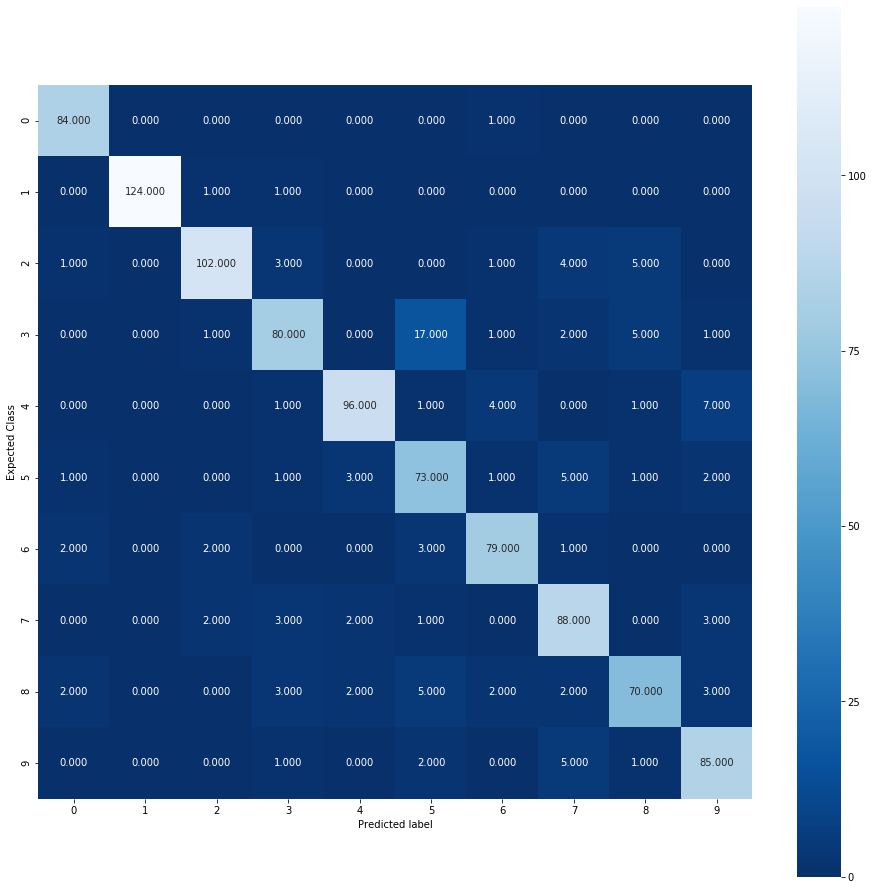

In [71]:
import seaborn as sns
confmat = metrics.confusion_matrix(expected, predicted)
plt.figure(figsize=(16,16))
sns.heatmap(confmat, annot=True, fmt=".3f", square = True, cmap = 'Blues_r')
plt.ylabel('Expected Class')
plt.xlabel('Predicted label')

### 誤認識された文字を見る
このコードで，mis_idx というリストに間違った文字の番号(index)が格納される

In [72]:
i = 0
mis_idx = []
for exp, pred in zip(expected, predicted):
    if exp != pred:
        print(i, exp, pred)
        mis_idx.append(i)
    i = i + 1

8 5 4
33 4 6
44 3 5
63 3 2
65 4 9
66 6 2
73 9 7
80 7 9
87 3 5
124 7 4
149 2 8
172 2 3
193 9 3
211 5 7
217 6 5
218 5 7
230 3 5
233 8 7
241 9 5
242 8 9
243 7 3
245 3 5
247 4 6
268 8 5
290 8 4
300 4 6
313 3 5
318 2 3
320 9 7
321 2 7
338 8 0
341 6 7
349 3 7
352 5 0
358 7 9
362 2 7
376 4 9
386 6 5
403 8 9
412 5 3
444 2 8
445 6 0
448 9 8
449 3 5
450 3 5
457 6 5
460 5 9
464 3 7
479 9 5
483 5 7
488 9 7
495 8 0
507 3 5
511 4 8
514 6 2
515 3 8
527 8 5
531 3 6
532 4 9
543 8 3
548 3 5
551 7 3
553 8 6
565 4 9
569 3 5
572 8 5
578 3 8
591 8 3
610 4 6
613 2 8
628 3 9
638 5 7
646 2 6
658 7 4
659 2 7
684 7 3
689 7 9
691 8 4
692 5 7
707 4 9
717 0 6
720 5 6
726 7 5
728 2 8
734 3 5
738 2 8
740 4 9
760 4 9
791 5 9
795 3 5
797 5 8
800 8 5
801 3 5
810 7 2
839 8 3
844 8 7
865 3 5
866 5 4
877 8 6
881 4 3
882 9 7
890 3 5
894 3 5
900 1 3
924 2 7
936 8 5
938 3 5
939 2 0
944 3 8
947 8 9
950 7 2
951 5 4
956 1 2
959 4 5
965 6 0
975 2 3
976 3 8
982 3 8
999 9 7


mis_idx の長さを見て(len()関数），何文字間違えたか見る

## 実際に誤認識した文字の画像を見る

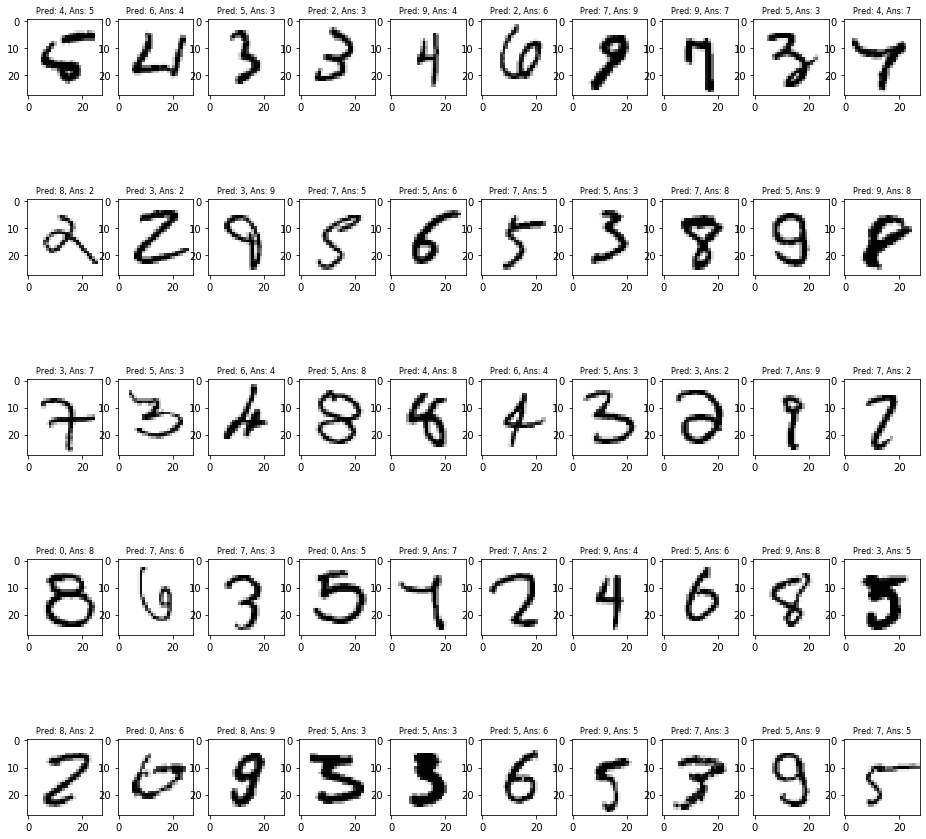

In [73]:
plt.figure(figsize=(16,16))
for i, ng in enumerate(mis_idx[0:50]):
    plt.subplot(5, 10, i + 1)
    plt.imshow(x_test[ng], cmap='gray_r')
    plt.title('Pred: {}, Ans: {}'.format(predicted[ng], expected[ng]), fontsize = 8)

## CNN (畳み込みニューラルネット) でディープラーニング

In [74]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

### データを少し加工する
CNN は2次元配列でデータを入力 (28x28のままで入力)

In [77]:
data_size = 1000

x_train1 = x_train.reshape(x_train.shape[0], 1, 28, 28).astype('float32')
x_test1 = x_test.reshape(x_test.shape[0], 1, 28, 28).astype('float32')
x_train1 = x_train1[0:data_size]
y_train1 = y_train[0:data_size]
x_test1 = x_test1[0:data_size]
y_test1 = y_test[0:data_size]
x_train1_n = x_train1 / 255
x_test1_n = x_test1 / 255

### モデルを定義
- Conv2D, MaxPooling という層が，独自の層（ディープラーニング用）

In [80]:
dnn = Sequential()
dnn.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
dnn.add(MaxPooling2D(pool_size=(2, 2)))
dnn.add(Dropout(0.2))
dnn.add(Flatten())
dnn.add(Dense(128, activation='relu'))
dnn.add(Dense(n_classes, activation='softmax'))

dnn.summary()
dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 24, 24)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 12, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
_________________________________________________________________


### モデルの学習
- epochsは本当は大きい方が望ましいが，ここは8にしておく(計算時間のため)

In [81]:
history_dnn = dnn.fit(x_train1_n, y_train_c,
                    batch_size=32,
                    epochs=8,
                    verbose=1,
                    validation_data=(x_test1_n, y_test_c))

Train on 1000 samples, validate on 1000 samples
Epoch 1/8
1000/1000 [==============================] - 2s 2ms/step - loss: 1.1998 - acc: 0.6550 - val_loss: 0.8511 - val_acc: 0.7380
Epoch 2/8
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4160 - acc: 0.8720 - val_loss: 0.4335 - val_acc: 0.8630
Epoch 3/8
1000/1000 [==============================] - 1s 1ms/step - loss: 0.2452 - acc: 0.9340 - val_loss: 0.3439 - val_acc: 0.8950
Epoch 4/8
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1949 - acc: 0.9420 - val_loss: 0.3745 - val_acc: 0.8690
Epoch 5/8
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1487 - acc: 0.9570 - val_loss: 0.3237 - val_acc: 0.8960
Epoch 6/8
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0913 - acc: 0.9800 - val_loss: 0.3146 - val_acc: 0.8980
Epoch 7/8
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0561 - acc: 0.9910 - val_loss: 0.3453 - val_acc: 0.8960
Epoch 8/8
1000/1000 [

#### 精度を評価

In [82]:
score_dnn = dnn.evaluate(x_test1_n, y_test_c, verbose=1)
print('Test loss:', score_dnn[0])
print('Test accuracy:', score_dnn[1])

1000/1000 [==============================] - 0s 221us/step
Test loss: 0.3305629140138626
Test accuracy: 0.899


- history オブジェクトにある情報で，学習の進展を見る

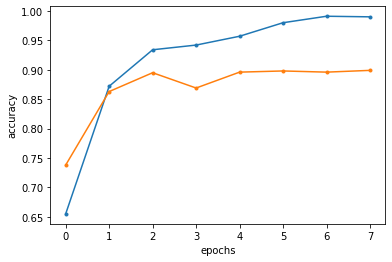

In [83]:
import matplotlib.pyplot as plt
plt.plot(history_dnn.history['acc'], marker='.', label='acc')
plt.plot(history_dnn.history['val_acc'], marker='.', label='val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

### 深層学習モデルの保存

```
dnn.save('dnn.h5')
```

In [84]:
dnn.save('dnn.h5')

### 更に深いネットワークの例

In [85]:
dnn2 = Sequential()
dnn2.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
dnn2.add(MaxPooling2D(pool_size=(2, 2)))
dnn2.add(Dropout(0.25))
dnn2.add(Conv2D(64, (3, 3), input_shape=(1, 28, 28), activation='relu'))
dnn2.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
dnn2.add(Dropout(0.25))
dnn2.add(Flatten())
dnn2.add(Dense(256, activation='relu'))
dnn2.add(Dropout(0.5))
dnn2.add(Dense(n_classes, activation='softmax'))

dnn2.summary()
dnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 24, 24)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 10, 10)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 5, 5)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 5, 5)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
__________

### モデルの学習

In [86]:
history_dnn2 = dnn2.fit(x_train1_n, y_train_c,
                        batch_size=32,
                        epochs=8,
                        verbose=1,
                        validation_data=(x_test1_n, y_test_c))

Train on 1000 samples, validate on 1000 samples
Epoch 1/8
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9426 - acc: 0.3520 - val_loss: 1.1492 - val_acc: 0.6990
Epoch 2/8
1000/1000 [==============================] - 2s 2ms/step - loss: 0.8691 - acc: 0.7130 - val_loss: 0.5655 - val_acc: 0.8180
Epoch 3/8
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4929 - acc: 0.8510 - val_loss: 0.3651 - val_acc: 0.8970
Epoch 4/8
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3469 - acc: 0.9000 - val_loss: 0.2870 - val_acc: 0.9130
Epoch 5/8
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2298 - acc: 0.9310 - val_loss: 0.2727 - val_acc: 0.9050
Epoch 6/8
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2065 - acc: 0.9420 - val_loss: 0.2442 - val_acc: 0.9190
Epoch 7/8
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2013 - acc: 0.9390 - val_loss: 0.2294 - val_acc: 0.9230
Epoch 8/8
1000/1000 [

- history オブジェクトにある情報で，学習の進展を見る

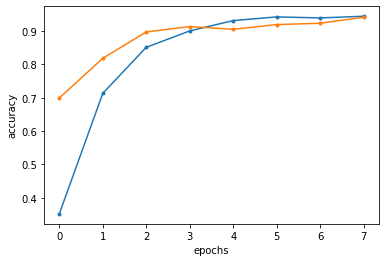

In [87]:
import matplotlib.pyplot as plt
plt.plot(history_dnn2.history['acc'], marker='.', label='acc')
plt.plot(history_dnn2.history['val_acc'], marker='.', label='val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [88]:
dnn2.save('dnn2.h5')

## これまでに学習したモデルの性能を比較
ここまで，

* 単層パーセプトロン
* 多層パーセプトロン
* 深層学習

を学習・評価しました．

それぞれの，学習過程と認識結果はそれぞれ `history_*` と `score_*` に保存されています

| 手法 | model | history | score |
|:---:| :---: | :-----: | :---: |
| 単層パーセプトロン | `perceptron` | `history_perceptron` | `score_perceptron` |
| 多層パーセプトロン | `mlp` | `history_mlp` | `score_mlp` |
| 深層学習 | `dnn` | `history_dnn` | `score_dnn` |
| 深層学習 | `dnn2` | `history_dnn2` | `score_dnn2` |

まずは，学習データに対する結果の比較

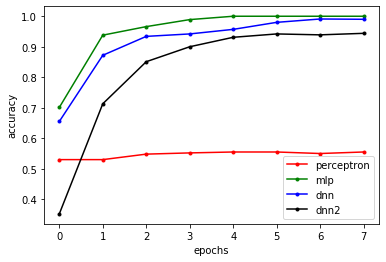

In [89]:
plt.plot(history_perceptron.history['acc'], marker='.', color='r', label='perceptron')
plt.plot(history_mlp.history['acc'], marker='.',color='g', label='mlp')
plt.plot(history_dnn.history['acc'], marker='.', color='b', label='dnn')
plt.plot(history_dnn2.history['acc'], marker='.', color='k', label='dnn2')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

モデルごとの識別率を比較してみてください

次に，テストデータに対する結果の比較

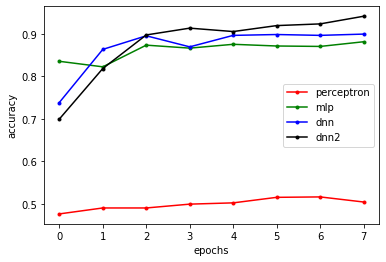

In [90]:
plt.plot(history_perceptron.history['val_acc'], marker='.', color='r', label='perceptron')
plt.plot(history_mlp.history['val_acc'], marker='.', color='g', label='mlp')
plt.plot(history_dnn.history['val_acc'], marker='.', color='b', label='dnn')
plt.plot(history_dnn2.history['val_acc'], marker='.', color='k', label='dnn2')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()